In this example we will look at using suspect with Siemens TWIX data. TWIX is a raw data format which gives us access to the data from each individual channel and repetition, which is essential for certain advanced processing techniques. The data in this file is from a single voxel PRESS acquisition which is signficantly affected by a drift in the B0 frequency which causes peak broadening, which we will correct for using suspect.

As always, we start by importing the modules we are going to need.

In [2]:
import suspect
import numpy as np
from matplotlib import pyplot
# tell jupyter that we want all plots to be shown in the document
%matplotlib inline

Now we load the data file we are interested in using the `load_twix` function from suspect's `io` module.

In [3]:
data = suspect.io.load_twix("/home/jovyan/suspect/tests/test_data/siemens/twix_vb.dat")

`data` is an instance of the `MRSData` class, which is a subclass of `numpy.ndarray` that adds MRS specific properties and methods, so that we can for example find out the Larmor frequency of the scanner, or the echo time of the data

In [4]:
data.f0

123.26171599999999

In [5]:
data.te

30

In [6]:
data.shape

(128, 32, 2048)

When we look at the shape of the data object, we see that it has three dimensions. The last dimension is the ADC values acquired during readout. The middle dimension is the data from the individual coils of the 32 channel head coil used to acquire this dataset, and the first dimension is for the 128 repetitions performed to improve the signal to noise ratio (SNR). Other types of data may have different numbers of dimensions: CSI datasets have 2 or 3 spatial components, MEGAPRESS sequences have an on/off dimension and COSY/JPRESS have an increment component.

The first step in processing this single voxel data is to combine the data from all the individual channels. We could just average them all together, but this won't give the maximum signal to noise ratio. We want to give a stronger weighting to the channels which already have the highest SNR and we can do this using the `svd_weighting` function provided by suspect in the `processing.channel_combination` module.

In [7]:
# average repetitions
averaged_data = np.average(data, axis=0)
# calculate channel weights
channel_weights = suspect.processing.channel_combination.svd_weighting(averaged_data)
# combine channels according to weights
combined_data = data.inherit(np.average(averaged_data, axis=0, weights=channel_weights))

(5.2, 0)

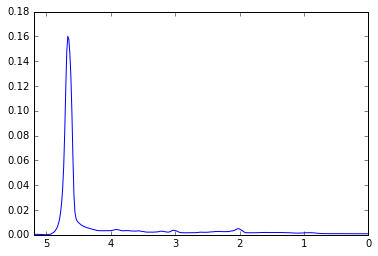

In [9]:
pyplot.plot(data.frequency_axis_ppm(), np.imag(combined_data.spectrum()))
pyplot.xlim([5.2, 0])
#pyplot.ylim([0, 0.008])

In [9]:
# combine channels without averaging repetitions
cc_data = data.inherit(np.average(data, axis=1, weights=channel_weights))
# calculate frequency shifts
shifts = map(suspect.processing.frequency_correction.spectral_registration, cc_data, cc_data[0])
# zip the fids with the transforms
pairs = zip(np.split(cc_data, cc_data.shape[0]), shifts)
# apply the transforms to the fids
transformed_fids = [suspect.processing.frequency_correction.transform_fid(f, -s[0], s[1]) for f, s in pairs]
# recombine the individual fids
fc_data = data.inherit(np.stack(transformed_fids)).squeeze()
# average the frequency corrected repetitions
result = data.inherit(np.average(fc_data, axis=0))

(0, 0.008)

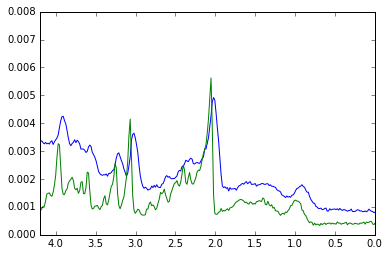

In [10]:
pyplot.plot(data.frequency_axis_ppm(), np.real(np.fft.fftshift(np.fft.fft(-1j*combined_data))))
pyplot.plot(data.frequency_axis_ppm(), np.real(np.fft.fftshift(np.fft.fft(-1j*result))))
pyplot.xlim([4.2, 0])
pyplot.ylim([0, 0.008])